In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

from plotly.subplots import make_subplots
from matplotlib import cm
from fancy_matrix import generate_matrix


plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

### Definition of multivariate non homogeneus non separable quadratic function
$$ f(x) = \frac{1}{2}x^TQx = \frac{1}{2} \sum_{i=1}^{n} Q_{ii}x_i^2 +\sum_{i=1}^{n}\sum_{j=1, j\not=i}^{n} Q_{ij}x_ix_j \qquad Q \in \mathbb{R}^{n \times n}, x \in \mathbb{R}^{n} $$

In [3]:
"""
Just implement the above shown formula for non homogeneus non separable quadratic function
"""
from matplotlib.pyplot import title


def MQF(Q, x):
    return np.dot(np.dot(x, Q), np.transpose(x))

def create_surface(Q, start=-10, stop=10, step=0.5):
    if(Q.shape[0] > 2): 
        raise ValueError("Q must be a 2x2 matrix.")

    x1s = x2s = np.arange(start, stop, step)
    X, Y = np.meshgrid(x1s, x2s)
    
    zs = []
    for x1 in x1s:
        for x2 in x2s:
            zs.append(MQF(Q, np.array([x1, x2])))

    Z = np.reshape(zs, X.shape)

    return X, Y, Z


"""
Implements plotting for 2-variate quadratic functions. Just plot 3D surface and level sets for z variable.
It also shows eigenvalues for given Q matrix
Throws ValueError if dim(Q) > 2
Available engines for plotting: matplotlib (default), plotly
"""
def plot_mqf3D(Q, start=-10, stop=10, step=0.5, engine='matplotlib'):

    if engine == 'plotly':
        lambda1, lambda2 = np.linalg.eig(Q)[0][0], np.linalg.eig(Q)[0][1]
        lambda1, lambda2 = np.round(lambda1, 2), np.round(lambda2, 2)
        X, Y, Z = create_surface(Q, start, stop, step)
        fig = make_subplots(rows=1, cols=2, 
            specs=[[{"type": "surface"}, {}]])

        fig.add_trace(go.Surface(x=X, y=Y, z=Z), row=1, col=1)
        fig.add_trace(go.Contour(z=Z), row=1, col=2)
        fig.update_layout(title_text=f'\u03BB = [{lambda1}, {lambda2}]')
        fig.update_yaxes(scaleanchor='x', scaleratio=1)
        fig.show()
    
    else:
        plot_matplotlib(Q, start, stop, step)
    
"""
Same as above, but plot with Matplotlib for static charts.
"""
def plot_matplotlib(Q, start=-10, stop=10, step=0.5):

    lambda1, lambda2 = np.linalg.eig(Q)[0][0], np.linalg.eig(Q)[0][1]
    lambda1, lambda2 = np.round(lambda1, 2), np.round(lambda2, 2)

    X, Y, Z = create_surface(Q, start, stop, step)
    fig = plt.figure()
    fig.suptitle(f'Multivariate quadratic non homogeneus function with eigenvalues \u03BB = [{lambda1}, {lambda2}]')

    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.Oranges)
    ax.set_title('3D surface')

    contour = fig.add_subplot(122)
    contour.contour(Z)
    contour.axis('square')
    contour.set_title('Level Set')
    
    fig.tight_layout()
    plt.show()


#### First case: eigenvalues strictly negative.

In the figure below is shown that for strictly negative eigenvalues the curve level sets are _ellipsoids_.

Surface has its concavity faced to the negative side of the chart.

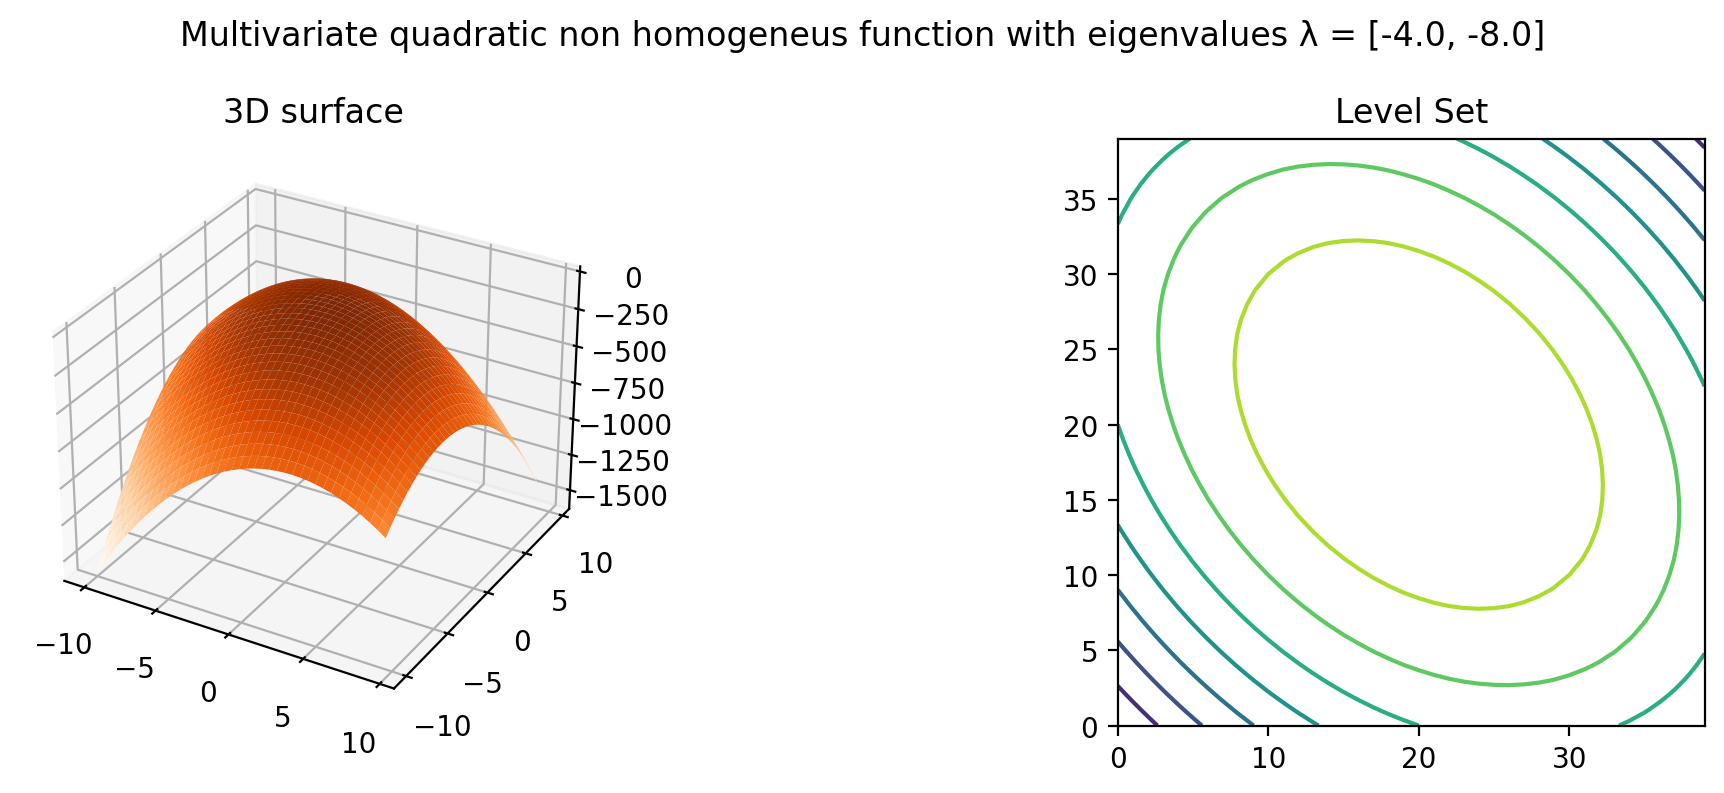

In [4]:
m = np.array([[-6, -2], [-2, -6]]) # eigenvalues are -8, -4
plot_mqf3D(m)


#### Second case: eigenvalues strictly positive.

Same as above, but now, eigenvalues are strictly positive. 

Concavity now faced towards the positive side of z axis of the chart.

Level sets are again ellipsoids. Note that level sets are "rotated" by 90 degrees since eigenvalues sign and order has changed for both

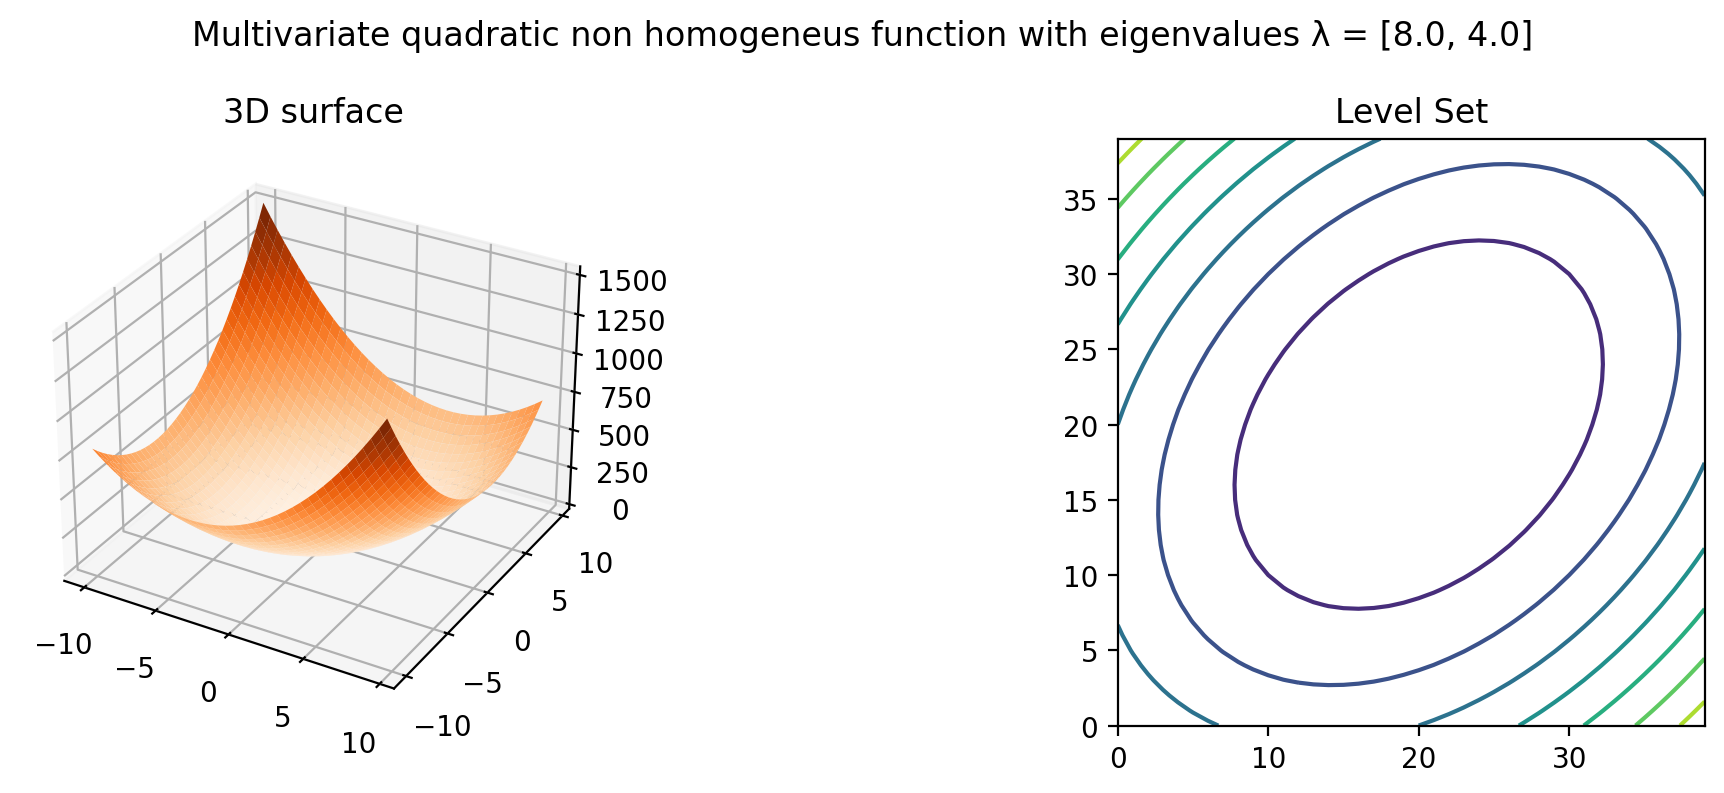

In [5]:
m = np.array([[6,-2], [-2, 6]]) #eigenvalues are 8, 4
plot_mqf3D(m)

#### Third case: one of the eigenvalues is zero

Level sets are degenerated ellipsoids.

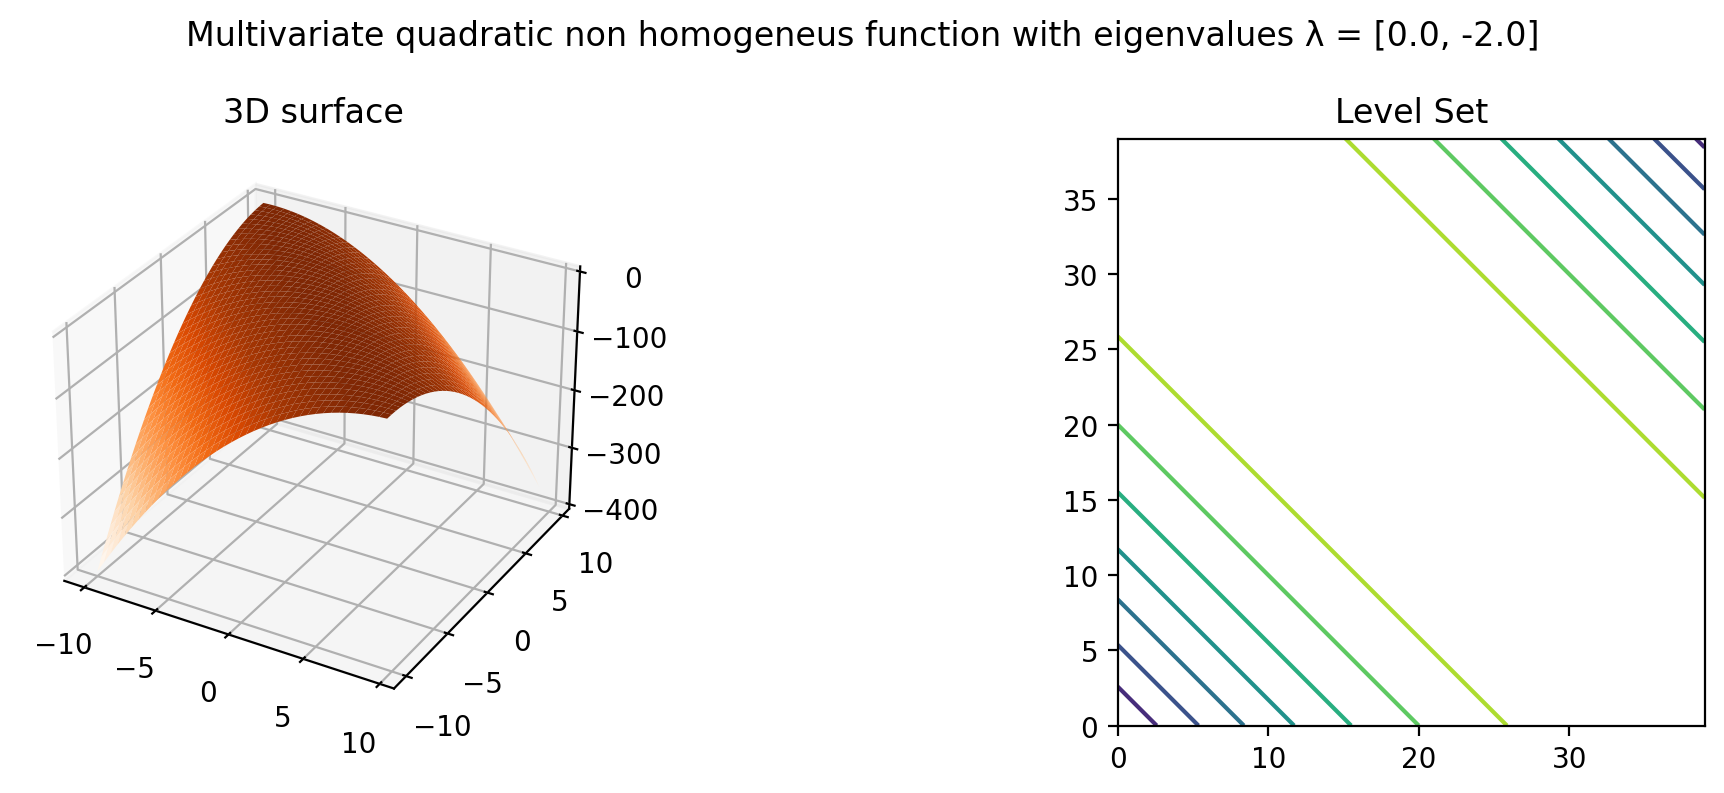

In [6]:
m = np.array([[-1, -1], [-1, -1]]) #eigenvalues are 0, -2
plot_mqf3D(m)

#### Fourth case: 2 coincidents eigenvalues

Level sets are perfect circles. (We just used the idendity matrix)

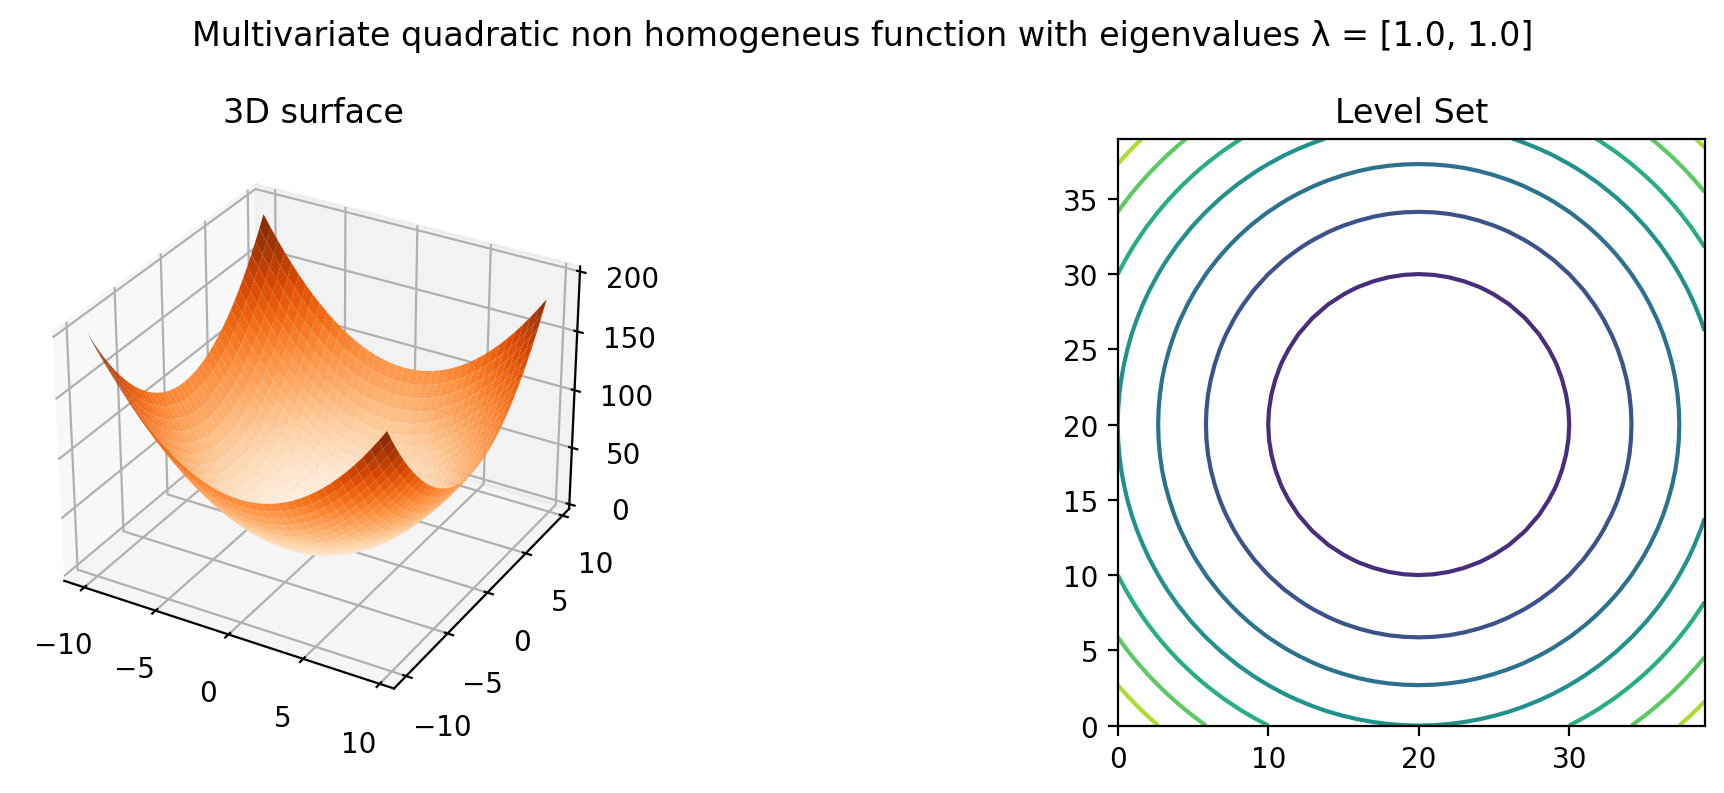

In [7]:
m = np.array([[1, 0], [0, 1]]) #eigenvalues are 1, 1
plot_mqf3D(m)

### Fifth case: one eigenvalue is positive, the other is negative.
Hyperboloids.


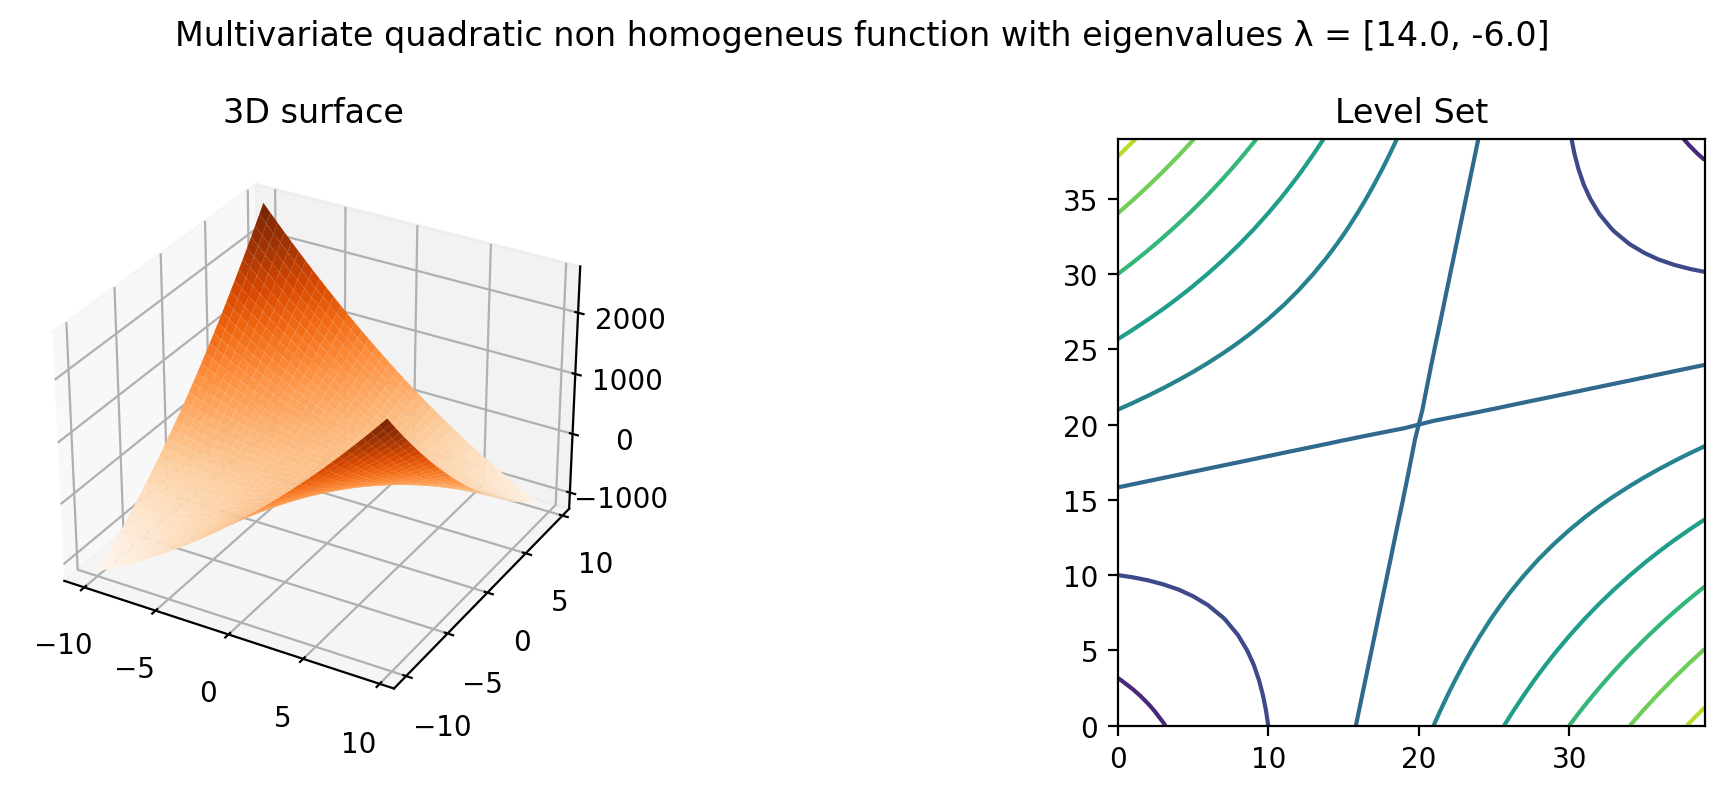

In [8]:
m = np.array([[4,-10], [-10, 4]])
plot_mqf3D(m)

# Optimizing multivariate quadratic functions
If we're lucky, optimizing such a function will result in solving the linear system $Qx=-q$, which we know it has a computational cost of $O(n^3)$.
Can be doable for small $n$, but for $n \approx 10^{9+}$ this computation becomes nearly impossible. 

## Iterative methods for solving multivariate quadratic optimization problems
Intuitively: choose a starting vector $x_0$ (random guessing is fine!), an then compute a new vector $x_1$ that _fits_ better than $x_0$ the problem. Repeat this process until a _close enough_ solution has been found by the algorithm. This sequence of solutions must have the property of _going towards the solution_. If we consider $f_*$ as the optimal value for our function, in most cases we cannot reach this point in finite time.

## Gradient method: general idea
Given that an exact computation would take infinite time (as we're simply approaching to the series' limit). Now, we know that the solution of the system $Qx=-q \iff Qx + q = 0 $ is the exact minimum of our multivariate quadratic equation. What if we compute the gradient $g$ of the series at a certain point $x_i$ and measure _how far_ is $g$ from zero, and then move to another solution $x_{i+1}$ that improves our gradient? How could we reach this result? In general, we could consider the tomography ($\varphi$) of the function with respect to the solution $x^i$, along the direction $-g^{(i)}$, as defined below:
$$\varphi_{x^{(i)}, -g^{(i)}}(\alpha) = f(x^{(i)} - \alpha g^{(i)}) - f(x^{(i)}) = ... = \frac{1}{2}\alpha ^2(g^{(i)})^TQg^{(i)} -\alpha \lVert g^{(i)} \rVert ^2$$
Now, _simply_ note that the term $\frac{1}{2}\alpha ^2(g^{(i)})^TQg^{(i)}$ is always positive, and $-\alpha \lVert g^{(i)} \rVert ^2$ is always negative.

In conclusion, for some _(carefully chosen)_ $\alpha > 0$, we notice that $\varphi_{x^i, -g^i}(\alpha) < 0$ which implies that for that $\alpha$ $f(x^{(i)} - \alpha g^{(i)}) < f(x^{(i)})$.

(Note: if you're really interested you can find all the omitted steps in the course's slides. Other useful materials can be found [here](https://www.cs.ccu.edu.tw/~wtchu/courses/2014s_OPT/Lectures/Chapter%208%20Gradient%20Methods.pdf) and [here](https://www.princeton.edu/~aaa/Public/Teaching/ORF363_COS323/F14/ORF363_COS323_F14_Lec8.pdf))

### Gradient method: what about complexity?

We just saw that minimizing $f$ with gradient method could be more easy ans hopefully less expensive, computationally speaking. In fact, computing $g^i$ and alpha is _only_ $O(n^2)$. We are far away from solving the whole system, which requires $O(n^3)$ computational steps.

The following C-like pseudocode better explains the algorithm.

```
void SDQ(Q, q, x, eps){
    while(true){
        g = Q*x + q;
        if(norm(g) <= eps) break;
        alpha = norm(g)**2 / (transpose(g)*Q*g); 
        x = x − alpha*g;
    }
}
```

### Gradient method: how to choose alpha?

Defined the optimal stepsize as $$\alpha_* =  \frac{\lVert d \rVert^2}{d^TQd }$$, we can easily notice that computing the optimal alpha is $O(n^2)$ (See matrix multiplication computaitonal cost). What an expensive operation to be repeatet at each step! Could we improve this result? Of course, yes. In fact $\alpha_*$ is the optimal step size, but every $\alpha \in (0, 2\alpha_*)$ provides $f_{i+1} < f_i $ (for this result's proof, check course material). Just notice that very small values for alpha will lead to very small improvements towards function minimum, and very large ones will easily lead the algorithm to miss the optimum. We also provide another fundamental observation: $\alpha_* \leq \lambda_1$ (with $\lambda_1$ defined as Q greatest eigenvalue) (proof of this statement on course material).

With these two trivial observations, we could reach another more efficient algorithm.
Just another problem: computing eigenvalues for a matrix is an optimization problem itself.
Solution: overstimate the largest eigenvalue for Q, as shown below 
$$\lambda_1 \leq \lVert Q \rVert_F = \sqrt{\sum_{i=0}^{n}\sum_{j=0}^{n}Q_{ij}^2}$$
The above formula is also called Frobenius Norm. Proof of this statement in course material.

### Gradient descent algorithm in practice
The following part will include gradient descent algorithm in python

In [16]:
def SGD(Q, alpha, q, x, eps=10e-6, verbose=False):
    print('> Gradient descent method for multivariate functions')
    g = np.array([]).flatten()
    err = np.Inf
    its = 0
    
    while err > eps:
        g = np.add(np.dot(Q, x), q)
        x = np.add(x, (-1*alpha * g))
        err = np.linalg.norm(g)
        if verbose:
            print(f'> New iteration: step n.{its}\t norm(g) (err) {err}')
        its += 1

    print(f'> Solution found: in {its} steps. Error {err}')
    
    return x, err


In [17]:
Q, q, eigs, ecc =  generate_matrix(5000, 10, 9)
q= q.flatten()
print(f'> Generated matrix of size {Q.shape[0]} with eccentricity = {ecc}')

alpha = 0.05
x, err = SGD(Q, alpha, q.flatten(), np.zeros(Q.shape[0]), verbose=True)


> Generated matrix of size 5000 with eccentricity = 0.05263157894736842
> Gradient descent method for multivariate functions
> New iteration: step n.0	 norm(g) (err) 387.23151055584026
> New iteration: step n.1	 norm(g) (err) 203.0695776087386
> New iteration: step n.2	 norm(g) (err) 106.65592240593008
> New iteration: step n.3	 norm(g) (err) 56.103422548112405
> New iteration: step n.4	 norm(g) (err) 29.55655771348382
> New iteration: step n.5	 norm(g) (err) 15.594515992585478
> New iteration: step n.6	 norm(g) (err) 8.240140730959869
> New iteration: step n.7	 norm(g) (err) 4.360447059510632
> New iteration: step n.8	 norm(g) (err) 2.310723995068322
> New iteration: step n.9	 norm(g) (err) 1.2262274611129018
> New iteration: step n.10	 norm(g) (err) 0.6516037982021429
> New iteration: step n.11	 norm(g) (err) 0.3467114408003147
> New iteration: step n.12	 norm(g) (err) 0.1847166557337964
> New iteration: step n.13	 norm(g) (err) 0.09853210294958095
> New iteration: step n.14	 norm(g)

In [11]:
x.shape


(1000,)

In [12]:
x

array([ 6.86543671e-01,  2.36087834e-02, -4.43958850e-01, -9.60674928e-01,
        9.21326709e-01, -8.13268433e-02, -4.65898887e-01, -8.17218591e-01,
       -7.10806053e-01, -5.85341627e-01, -3.62965411e-01, -7.31730661e-01,
       -5.08421332e-01, -9.22538458e-01, -1.15662617e-01, -7.81480118e-01,
       -4.67844275e-01,  5.20401386e-01,  5.99103801e-01,  1.25289970e-01,
        5.97077669e-01, -1.14498527e-02, -8.71375333e-01, -2.25459723e-01,
        2.09012445e-01, -2.73250286e-01,  8.46796058e-01, -2.97453827e-01,
       -1.07588091e-01, -9.56477324e-01, -8.90601076e-01, -9.08396933e-01,
       -3.76351159e-01, -2.10316211e-01, -5.03209693e-01, -2.82978089e-01,
        2.79908026e-01,  4.67911227e-02,  4.82916538e-02,  9.44624128e-01,
        2.66479828e-01,  1.76414990e-01, -8.96719502e-01, -7.99139770e-02,
       -6.00686347e-01, -5.40406372e-01,  4.74347319e-01, -6.50808028e-01,
       -4.26983395e-01,  7.91921155e-01,  9.39722495e-01,  4.08369459e-01,
        7.22537518e-01,  